## 사용 패키지

In [92]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor

## 데이터 로드

In [93]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')

temp = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/진주체감온도.csv')

In [94]:
temp.columns = ['일자','기온','풍속','체감기온']

In [95]:
train = pd.merge(train, temp)
test = pd.merge(test, temp)

In [96]:
train['체감기온']

0      -1.1
1      -2.7
2      -2.2
3      -0.8
4       1.2
       ... 
1200   -0.9
1201    4.6
1202    7.0
1203    6.3
1204    4.8
Name: 체감기온, Length: 1205, dtype: float64

In [97]:
test['체감기온']

0      4.1
1     -0.1
2     -4.4
3      7.2
4     -0.4
5     -2.5
6      2.2
7      0.7
8      1.4
9     -0.3
10     1.6
11     6.5
12    -0.4
13    -6.5
14    -4.2
15     1.5
16    14.8
17     7.0
18     3.6
19     3.7
20     8.2
21     5.3
22     3.3
23     4.9
24    10.5
25     6.6
26     9.5
27     8.5
28     8.8
29     8.7
30     9.9
31    14.5
32     9.1
33    10.4
34    12.2
35     6.3
36     8.2
37    10.1
38    12.1
39    12.3
40    14.0
41    12.5
42    12.0
43    13.7
44    16.7
45    10.7
46    10.8
47    13.0
48    13.1
49    10.4
Name: 체감기온, dtype: float64

## 데이터

## 요일을 숫자로 매핑

In [98]:
#train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
#test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

## `요일 랭크지정 방식.`
## 석식에만 적용! 석식 수요일이 자기개발의 날 때문에 적어서.

In [99]:
weekdayrankfordinner = {
    '월' : 1,
    '화' : 2,
    '수' : 5,
    '목' : 3,
    '금' : 4
} 

train['요일(석식)'] = train['요일'].map(weekdayrankfordinner)
test['요일(석식)'] = test['요일'].map(weekdayrankfordinner)

## `월, 일을 숫자형으로 변환`

In [100]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week
train['요일'] = train['일자'].dt.weekday


test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week
test['요일'] = test['일자'].dt.weekday

train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]


C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='월', ylabel='중식계'>

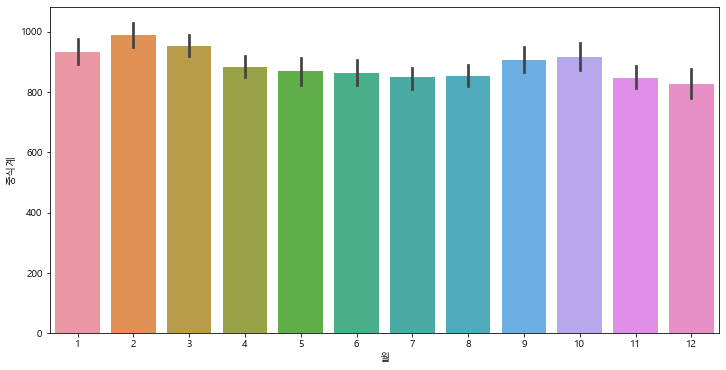

In [101]:
plt.figure(figsize=(12,6))
sns.barplot(train['월'], train['중식계'])

C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='월', ylabel='석식계'>

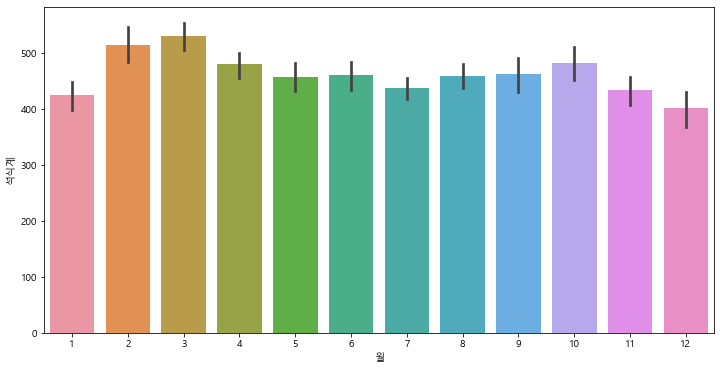

In [102]:
plt.figure(figsize=(12,6))
sns.barplot(train['월'], train['석식계'])

In [103]:
sampletrain = train.loc[:,('월','중식계','석식계')]
sampletrain.groupby(['월']).mean()

중식계         석식계
월                         
1   934.247525  424.564356
2   989.623656  514.860215
3   953.607477  530.700935
4   883.621359  480.825243
5   869.787879  458.131313
6   863.311111  460.355556
7   848.736364  437.300000
8   854.785047  459.485981
9   907.148936  463.617021
10  917.771739  481.641304
11  847.333333  434.250000
12  827.336634  401.168317

## `월 랭크지정 방식` 낮은게 12 큰게 1 요일 랭크와 동일

In [104]:
month1 = {
    1:2,
    2:3,
    3:1,
    4:10,
    5:9,
    6:4,
    7:5,
    8:6,
    9:8,
    10:7,
    11:11,
    12:12
}

month2 = {
    1:3,
    2:2,
    3:10,
    4:4,
    5:9,
    6:6,
    7:8,
    8:5,
    9:7,
    10:11,
    11:1,
    12:12
}
train['월(중식)'] = train['월'].map(month1)
test['월(중식)'] = test['월'].map(month1)

train['월(석식)'] = train['월'].map(month2)
test['월(석식)'] = test['월'].map(month2)

train['월(중식)'] = train['월(중식)'].astype('int') # float형이라 int로 변경
test['월(중식)'] = test['월(중식)'].astype('int')
train['월(석식)'] = train['월(석식)'].astype('int')
test['월(석식)'] = test['월(석식)'].astype('int')

In [105]:
train

일자  요일  본사정원수  본사휴가자수  본사출장자수  본사시간외근무명령서승인건수  현본사소속재택근무자수  \
0    2016-02-01   0   2601      50     150             238          0.0   
1    2016-02-02   1   2601      50     173             319          0.0   
2    2016-02-03   2   2601      56     180             111          0.0   
3    2016-02-04   3   2601     104     220             355          0.0   
4    2016-02-05   4   2601     278     181              34          0.0   
...         ...  ..    ...     ...     ...             ...          ...   
1200 2021-01-20   2   2983      75     198               4        391.0   
1201 2021-01-21   3   2983      92     231             462        351.0   
1202 2021-01-22   4   2983     255     248               1        303.0   
1203 2021-01-25   0   2983     107     153             616        327.0   
1204 2021-01-26   1   2983      69     183             551        362.0   

                                                   조식메뉴  \
0     모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐...   
1     모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌...   
2     모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...   
3     모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국...   
4     모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방...   
...                                                 ...   
1200  모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...   
1201  모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...   
1202  모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...   
1203  모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...   
1204  모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 ...   

                                                   중식메뉴  \
0     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 (쇠고기:호주산) 계란찜 ...   
1     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개  가자미튀김  모둠소세지구이  마늘쫑무...   
2     카레덮밥 (쌀,현미흑미:국내산) 팽이장국  치킨핑거 (닭고기:국내산) 쫄면야채무침 ...   
3     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국  주꾸미볶음  부추전  시금치나물  ...   
4     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국  돈육씨앗강정 (돼지고기:국내산) 우엉잡채...   
...                                                 ...   
1200  쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...   
1201  쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...   
1202  전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...   
1203  쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...   
1204  쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...   

                                                   석식메뉴  ...   기온   풍속  체감기온  \
0     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장  자반고등어구이  두부조림  건파래무침 ...  ... -0.2  1.3  -1.1   
1     콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국  유산슬 (쇠고기:호주산) 아삭고추무...  ... -2.3  0.8  -2.7   
2     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개  황태양념구이 (황태:러시아산) 고기...  ... -1.9  0.6  -2.2   
3     미니김밥*겨자장 (쌀,현미흑미:국내산) 우동  멕시칸샐러드  군고구마  무피클  포...  ... -0.6  0.7  -0.8   
4     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...  ...  1.5  1.0   1.2   
...                                                 ...  ...  ...  ...   ...   
1200     김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치   ... -0.9  0.5  -0.9   
1201            흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치   ...  4.6  0.6   4.6   
1202        흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치   ...  7.0  0.6   7.0   
1203            흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치   ...  6.5  1.0   6.3   
1204         (New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기   ...  4.9  0.5   4.8   

      요일(석식)     년  월   일  주  월(중식)  월(석식)  
0          1  2016  2   1  5      3      2  
1          2  2016  2   2  5      3      2  
2          5  2016  2   3  5      3      2  
3          3  2016  2   4  5      3      2  
4          4  2016  2   5  5      3      2  
...      ...   ... ..  .. ..    ...    ...  
1200       5  2021  1  20  3      2      3  
1201       3  2021  1  21  3      2      3  
1202       4  2021  1  22  3      2      3  
1203       1  2021  1  25  4      2      3  
1204       2  2021  1  26  4      2      3  

[1205 rows x 22 columns]

In [106]:
train.dtypes

일자                datetime64[ns]
요일                         int64
본사정원수                      int64
본사휴가자수                     int64
본사출장자수                     int64
본사시간외근무명령서승인건수             int64
현본사소속재택근무자수              float64
조식메뉴                      object
중식메뉴                      object
석식메뉴                      object
중식계                      float64
석식계                      float64
기온                       float64
풍속                       float64
체감기온                     float64
요일(석식)                     int64
년                          int64
월                          int64
일                          int64
주                          int32
월(중식)                      int32
월(석식)                      int32
dtype: object

In [107]:
train

일자  요일  본사정원수  본사휴가자수  본사출장자수  본사시간외근무명령서승인건수  현본사소속재택근무자수  \
0    2016-02-01   0   2601      50     150             238          0.0   
1    2016-02-02   1   2601      50     173             319          0.0   
2    2016-02-03   2   2601      56     180             111          0.0   
3    2016-02-04   3   2601     104     220             355          0.0   
4    2016-02-05   4   2601     278     181              34          0.0   
...         ...  ..    ...     ...     ...             ...          ...   
1200 2021-01-20   2   2983      75     198               4        391.0   
1201 2021-01-21   3   2983      92     231             462        351.0   
1202 2021-01-22   4   2983     255     248               1        303.0   
1203 2021-01-25   0   2983     107     153             616        327.0   
1204 2021-01-26   1   2983      69     183             551        362.0   

                                                   조식메뉴  \
0     모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐...   
1     모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌...   
2     모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...   
3     모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국...   
4     모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방...   
...                                                 ...   
1200  모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...   
1201  모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...   
1202  모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...   
1203  모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...   
1204  모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 ...   

                                                   중식메뉴  \
0     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 (쇠고기:호주산) 계란찜 ...   
1     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개  가자미튀김  모둠소세지구이  마늘쫑무...   
2     카레덮밥 (쌀,현미흑미:국내산) 팽이장국  치킨핑거 (닭고기:국내산) 쫄면야채무침 ...   
3     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국  주꾸미볶음  부추전  시금치나물  ...   
4     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국  돈육씨앗강정 (돼지고기:국내산) 우엉잡채...   
...                                                 ...   
1200  쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...   
1201  쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...   
1202  전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...   
1203  쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...   
1204  쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...   

                                                   석식메뉴  ...   기온   풍속  체감기온  \
0     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장  자반고등어구이  두부조림  건파래무침 ...  ... -0.2  1.3  -1.1   
1     콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국  유산슬 (쇠고기:호주산) 아삭고추무...  ... -2.3  0.8  -2.7   
2     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개  황태양념구이 (황태:러시아산) 고기...  ... -1.9  0.6  -2.2   
3     미니김밥*겨자장 (쌀,현미흑미:국내산) 우동  멕시칸샐러드  군고구마  무피클  포...  ... -0.6  0.7  -0.8   
4     쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...  ...  1.5  1.0   1.2   
...                                                 ...  ...  ...  ...   ...   
1200     김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치   ... -0.9  0.5  -0.9   
1201            흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치   ...  4.6  0.6   4.6   
1202        흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치   ...  7.0  0.6   7.0   
1203            흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치   ...  6.5  1.0   6.3   
1204         (New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기   ...  4.9  0.5   4.8   

      요일(석식)     년  월   일  주  월(중식)  월(석식)  
0          1  2016  2   1  5      3      2  
1          2  2016  2   2  5      3      2  
2          5  2016  2   3  5      3      2  
3          3  2016  2   4  5      3      2  
4          4  2016  2   5  5      3      2  
...      ...   ... ..  .. ..    ...    ...  
1200       5  2021  1  20  3      2      3  
1201       3  2021  1  21  3      2      3  
1202       4  2021  1  22  3      2      3  
1203       1  2021  1  25  4      2      3  
1204       2  2021  1  26  4      2      3  

[1205 rows x 22 columns]

In [108]:
print(train['요일'],train['요일(석식)'])

0       0
1       1
2       2
3       3
4       4
       ..
1200    2
1201    3
1202    4
1203    0
1204    1
Name: 요일, Length: 1205, dtype: int64 0       1
1       2
2       5
3       3
4       4
       ..
1200    5
1201    3
1202    4
1203    1
1204    2
Name: 요일(석식), Length: 1205, dtype: int64


## `식사가능자수 , 식사참여율`

In [109]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [110]:
#train['중식참여율'] = train['중식계'] / train['식사가능자수']
#train['석식참여율'] = train['석식계'] / train['식사가능자수']

#test['중식참여율'] = test['중식계'] / test['식사가능자수']
#test['석식참여율'] = test['석식계'] / test['식사가능자수']

# `0708 공휴일 전후 추가 `

In [111]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

In [112]:
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] =2
test['공휴일전후'][20] = 1

<ipython-input-112-63b230823310>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][17] = 1
<ipython-input-112-63b230823310>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][3] = 1
<ipython-input-112-63b230823310>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][62] = 1
<ipython-input-112-63b230823310>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [113]:
# 원핫인코딩
train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

In [114]:
test['공휴일전후_0'][20] =1
test['공휴일전후_1'][20] = 0

<ipython-input-114-c110fdca8db8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['공휴일전후_0'][20] =1
<ipython-input-114-c110fdca8db8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['공휴일전후_1'][20] = 0


## 수치 데이터만 피쳐로 선택

In [115]:
#x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [116]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #중식계
x2_train = train[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수','월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #석식계


y1_train = train['중식계']
y2_train = train['석식계']

x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]
x2_test = test[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수', '월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]

In [117]:
# check = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '중식계', '석식계', '월', '일']]

# plt.figure(figsize=(10,10)) # 도화지 크기를 키워줌
# sns.heatmap(check.corr(), annot = True) # seaborn의 heatmap 함수에 train.corr() 상관계수를 넣어준다.
                                        # annot < 수치도 같이 나타내줌

## 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

In [118]:
model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

## 학습

In [119]:
model1.fit(x1_train, y1_train) #중식계
model2.fit(x2_train, y2_train) #석식계

RandomForestRegressor(n_jobs=-1, random_state=42)

## 추론

In [120]:
pred1 = model1.predict(x1_test)
pred2 = model2.predict(x2_test)

## 결과 제출

In [121]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [84]:
submission.to_csv('baseline.csv', index=False)

In [88]:
# 여태까지 최고성적은 요일, 일, 월만 추가한 것이었음.

# `Kfold 적용 버전`

In [122]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [123]:
# model1 = cat
models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t))#, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x1_test))    


# model2 = cat
models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t))#, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x2_test))

In [124]:
pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

In [125]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [126]:
submission.to_csv('baselinemonth.csv', index=False)

- 0708 23:11

randomforest default mae로 바꿈(대회 측정방식)->mae:73 mse:66 오히려 mse가 더 좋게나왔음..

- 0709 00:28

출장자수 변수추가했더니 1점 높게나옴. 추가할 것

- 0709 20:35
    
체감온도 추가 효과 오히려 감소

- 0709 21:38
월 매핑함. 
효과는?